# SED Reconstruction Demo

This notebook demonstrates how to use the `spxquery.sed` module to reconstruct high-resolution spectra from SPHEREx narrow-band photometry.

## Overview

The reconstruction uses wavelet-based multi-scale regularization:

$$
\min_x \left( \|w(y - Hx)\|_2^2 + \lambda_{\text{low}} \|\Psi_{\text{approx}} x\|_1 + \lambda_{\text{detail}} \|\Psi_{\text{detail}} x\|_1 \right)
$$

where:
- **Data fidelity**: Weighted chi-squared (L2 norm)
- **Approximation regularization**: L1 penalty on low-frequency wavelet coefficients (continuum)
- **Detail regularization**: L1 penalty on high-frequency wavelet coefficients (noise suppression)

In [22]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import SED reconstruction module
from spxquery.sed import (
    SEDConfig,
    SEDReconstructor,
    export_default_sed_config,
    reconstruct_sed_from_csv,
)

# Configure matplotlib for better plots
%matplotlib inline
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

## 1. Data Preparation

We'll use one of the demo lightcurve CSV files. You can change this to test on different data.

In [23]:
# Select input CSV file
input_csv = Path("demo_data/spec_refine/39633446351407006_lc.csv")

# Define output directory
output_dir = Path("demo_data/spec_refine/output")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Input CSV: {input_csv}")
print(f"Output directory: {output_dir}")

Input CSV: demo_data/spec_refine/39633446351407006_lc.csv
Output directory: demo_data/spec_refine/output


### Preview the input data

In [24]:
# Load and preview lightcurve data
lc_data = pd.read_csv(input_csv)

print(f"Total measurements: {len(lc_data)}")
print(f"Bands present: {sorted(lc_data['band'].unique())}")
print(f"Wavelength range: {lc_data['wavelength'].min():.3f} - {lc_data['wavelength'].max():.3f} microns")
print(f"\nMeasurements per band:")
print(lc_data["band"].value_counts().sort_index())

# Show first few rows
print("\nFirst 5 measurements:")
lc_data.head()

Total measurements: 8171
Bands present: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
Wavelength range: 0.739 - 5.007 microns

Measurements per band:
band
D1    1158
D2    1632
D3    1333
D4    1140
D5    1601
D6    1307
Name: count, dtype: int64

First 5 measurements:


,obs_id,mjd,flux,flux_error,wavelength,bandwidth,flag,pix_x,pix_y,band,mag_ab,mag_ab_error
0,2025W17_4B_0010_1,60789.808862,676.733027,76.677259,3.817430,0.035885,2097152,669.836896,1961.540485,D5,16.823957,0.123019
1,2025W17_4B_0010_1,60789.808862,410.024154,42.728189,1.102934,0.025967,2097152,662.835479,1970.781411,D2,17.367976,0.113143
2,2025W17_4B_0010_2,60789.810372,467.998870,43.660439,1.102967,0.025968,2097152,662.776745,1970.636752,D2,17.224388,0.101290
3,2025W17_4B_0010_2,60789.810372,707.587683,76.942002,3.817474,0.035885,2097152,669.780716,1961.389063,D5,16.775549,0.118061
4,2025W17_4B_0010_3,60789.811864,423.645691,43.392450,1.128690,0.026806,2097152,662.374634,1855.759471,D2,17.332493,0.111208


## 2. Basic Reconstruction (Default Settings)

Let's start with a simple reconstruction using default hyperparameters.

In [40]:
# Create default configuration
config_basic = SEDConfig(
    lambda_low=0.0,  # Approximation coefficient regularization (continuum)
    lambda_detail=5.0,  # Detail coefficient regularization (noise suppression)
    resolution_samples=510,  # Output wavelength bins
    stitch_bands=True,  # Automatically stitch 6 bands
    auto_tune=False,  # Manual hyperparameters
    wavelet_family="gaus",  # Symlet-6 wavelet (default)
    # wavelet_level=5,
    wavelet_boundary_mode="zero",  # Wavelet boundary mode
    sigma_clip_window=51,
)

print("Configuration:")
print(f"  lambda_low (continuum): {config_basic.lambda_low}")
print(f"  lambda_detail (noise suppression): {config_basic.lambda_detail}")
print(f"  Wavelet family: {config_basic.wavelet_family}")
print(f"  Resolution: {config_basic.resolution_samples} wavelength bins")
print(f"  Auto-stitch bands: {config_basic.stitch_bands}")

ValueError: wavelet_family 'gaus' not recognized. Valid choices: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8, coif1, coif2, coif3, coif4, coif5... (run pywt.wavelist() for full list)

In [34]:
# Run reconstruction
reconstructor_basic = SEDReconstructor(config_basic)
result_basic = reconstructor_basic.reconstruct_from_csv(input_csv)

print("\nReconstruction complete!")
print(f"Bands reconstructed: {list(result_basic.band_results.keys())}")
print(f"Stitched spectrum: {result_basic.stitched_spectrum is not None}")

  -> Poor fit or underestimated errors (reduced chi-squared >> 1)
  -> Poor fit or underestimated errors (reduced chi-squared >> 1)
  -> Poor fit or underestimated errors (reduced chi-squared >> 1)
  -> Poor fit or underestimated errors (reduced chi-squared >> 1)
  -> Poor fit or underestimated errors (reduced chi-squared >> 1)



Reconstruction complete!
Bands reconstructed: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6']
Stitched spectrum: True


### View quality metrics

In [35]:
# Print quality metrics for each band
print("Quality Metrics (Reduced Chi-Squared):")
print("=" * 50)
for band, band_result in result_basic.band_results.items():
    metrics = band_result.validation_metrics
    print(f"{band}: χ²_ν = {metrics.chi_squared_reduced:.3f} (dof={metrics.degrees_of_freedom})")
    print(
        f"     Weighted residuals: mean={metrics.weighted_residual_mean:.3f}, std={metrics.weighted_residual_std:.3f}"
    )
    print(f"     Solver time: {band_result.solver_time:.2f} s")
    print()

Quality Metrics (Reduced Chi-Squared):
D1: χ²_ν = 3.885 (dof=519)
     Weighted residuals: mean=0.066, std=1.377
     Solver time: 0.06 s

D2: χ²_ν = 3.354 (dof=997)
     Weighted residuals: mean=0.049, std=1.473
     Solver time: 0.07 s

D3: χ²_ν = 2.804 (dof=708)
     Weighted residuals: mean=0.038, std=1.260
     Solver time: 0.07 s

D4: χ²_ν = 2.650 (dof=492)
     Weighted residuals: mean=0.041, std=1.122
     Solver time: 0.08 s

D5: χ²_ν = 1.619 (dof=926)
     Weighted residuals: mean=0.045, std=1.010
     Solver time: 0.08 s

D6: χ²_ν = 2.133 (dof=651)
     Weighted residuals: mean=0.068, std=1.077
     Solver time: 0.07 s



### Visualize the reconstructed spectrum

/var/folders/z5/qygyj_xj7dq109c9rzqq2wv40000gn/T/ipykernel_46576/807453025.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


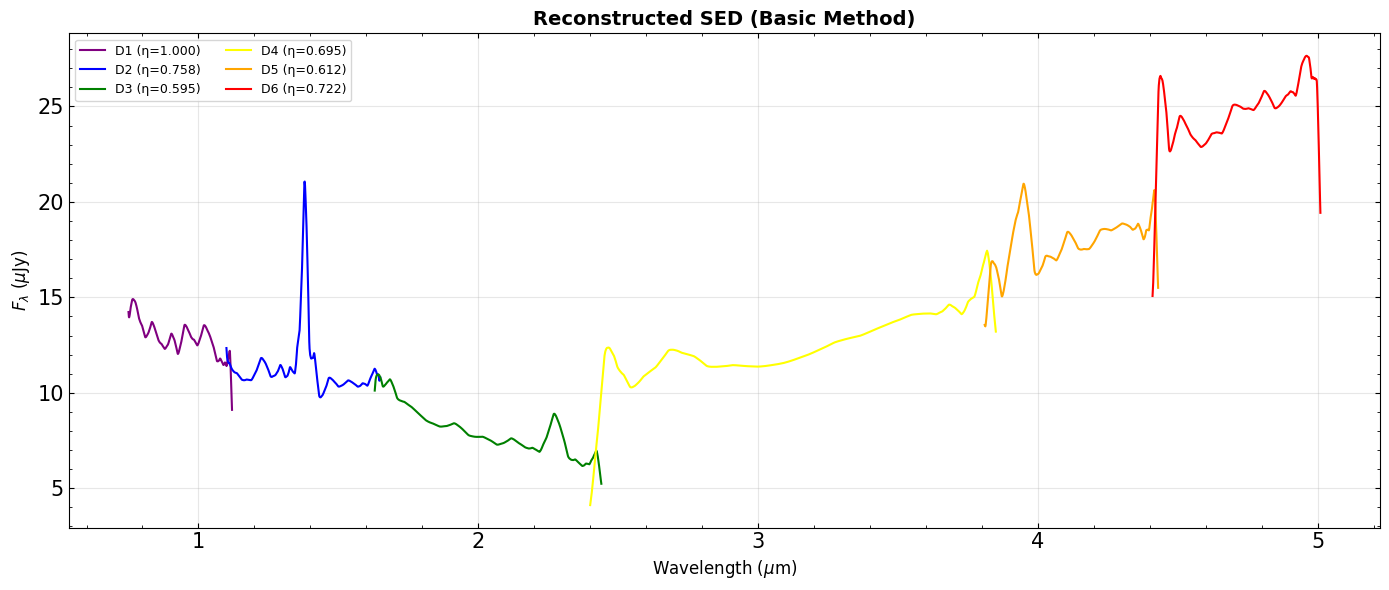

In [36]:
# Plot stitched spectrum if available
if result_basic.stitched_spectrum is not None:
    fig, ax = plt.subplots(figsize=(14, 6))

    stitched = result_basic.stitched_spectrum

    # Color code by band
    colors = {"D1": "purple", "D2": "blue", "D3": "green", "D4": "yellow", "D5": "orange", "D6": "red"}

    for band in ["D1", "D2", "D3", "D4", "D5", "D6"]:
        if band not in result_basic.band_results:
            continue
        mask = stitched.band_labels == band
        if np.any(mask):
            eta = stitched.normalization_factors[band]
            ax.plot(
                stitched.wavelength[mask],
                stitched.flux[mask],
                color=colors.get(band, "black"),
                linewidth=1.5,
                label=f"{band} (η={eta:.3f})",
            )

    ax.set_xlabel(r"Wavelength ($\mu$m)", fontsize=12)
    ax.set_ylabel(r"$F_\lambda$ ($\mu$Jy)", fontsize=12)
    ax.set_title("Reconstructed SED (Basic Method)", fontsize=14, fontweight="bold")
    ax.legend(loc="best", fontsize=9, ncol=2)
    ax.grid(alpha=0.3)
    # ax.set_ylim(0, 30)
    plt.tight_layout()
    plt.show()
else:
    print("No stitched spectrum available. Plotting individual bands.")

### Save results

In [14]:
# Save CSV and metadata
csv_path, yaml_path = result_basic.save_all(output_dir / "basic")

print(f"Saved results:")
print(f"  Spectrum CSV: {csv_path}")
print(f"  Metadata YAML: {yaml_path}")

Saved results:
  Spectrum CSV: demo_data/spec_refine/output/basic/sed_reconstruction.csv
  Metadata YAML: demo_data/spec_refine/output/basic/sed_metadata.yaml


## 3. Reconstruction with Auto-Tuning

Now let's enable automatic hyperparameter tuning via grid search. This finds optimal λ_low and λ_detail by minimizing validation error.

In [15]:
# Create config with auto-tuning enabled
config_tuned = SEDConfig(
    auto_tune=True,  # Enable grid search
    lambda_low_grid=[0.01, 0.1, 1.0, 10.0],  # Continuum regularization search grid
    lambda_detail_grid=[1.0, 10.0, 100.0, 1000.0],  # Noise suppression search grid
    validation_fraction=0.2,  # 80/20 train/validation split
    stitch_bands=True,
    resolution_samples=1020,
    wavelet_family="sym6",
)

print("Auto-tuning configuration:")
print(f"  λ_low grid (continuum): {config_tuned.lambda_low_grid}")
print(f"  λ_detail grid (noise): {config_tuned.lambda_detail_grid}")
print(f"  Total combinations: {len(config_tuned.lambda_low_grid) * len(config_tuned.lambda_detail_grid)}")
print(f"  Validation fraction: {config_tuned.validation_fraction}")
print(f"  Wavelet family: {config_tuned.wavelet_family}")

Auto-tuning configuration:
  λ_low grid (continuum): [0.01, 0.1, 1.0, 10.0]
  λ_detail grid (noise): [1.0, 10.0, 100.0, 1000.0]
  Total combinations: 16
  Validation fraction: 0.2
  Wavelet family: sym6


In [ ]:
# Run reconstruction with auto-tuning
# Note: This will take longer due to grid search
reconstructor_tuned = SEDReconstructor(config_tuned)
result_tuned = reconstructor_tuned.reconstruct_from_csv(input_csv)

print("\nAuto-tuned reconstruction complete!")

### View optimal hyperparameters

In [ ]:
# Print optimal hyperparameters for each band
print("Optimal Hyperparameters:")
print("=" * 50)
for band, band_result in result_tuned.band_results.items():
    print(f"{band}:")
    print(f"  Optimal λ_low: {band_result.lambda_low:.2e}")
    print(f"  Optimal λ_detail: {band_result.lambda_detail:.2e}")
    print(f"  χ²_ν: {band_result.validation_metrics.chi_squared_reduced:.3f}")

    if band_result.tuning_result is not None:
        print(f"  Validation error: {band_result.tuning_result.optimal_validation_error:.4f}")
        print(f"  Combinations tested: {band_result.tuning_result.n_evaluated}")
    print()

### Compare basic vs auto-tuned spectra

In [ ]:
# Plot comparison
if result_basic.stitched_spectrum is not None and result_tuned.stitched_spectrum is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Basic method
    ax = axes[0]
    for band in ["D1", "D2", "D3", "D4", "D5", "D6"]:
        if band not in result_basic.band_results:
            continue
        mask = result_basic.stitched_spectrum.band_labels == band
        if np.any(mask):
            ax.plot(
                result_basic.stitched_spectrum.wavelength[mask],
                result_basic.stitched_spectrum.flux[mask],
                linewidth=1.2,
                label=band,
            )
    ax.set_ylabel(r"$F_\lambda$ ($\mu$Jy)", fontsize=12)
    ax.set_title("Basic Method (λ_low=0.1, λ_detail=10.0)", fontsize=12, fontweight="bold")
    ax.legend(loc="best", fontsize=9, ncol=3)
    ax.grid(alpha=0.3)

    # Auto-tuned method
    ax = axes[1]
    for band in ["D1", "D2", "D3", "D4", "D5", "D6"]:
        if band not in result_tuned.band_results:
            continue
        mask = result_tuned.stitched_spectrum.band_labels == band
        if np.any(mask):
            ax.plot(
                result_tuned.stitched_spectrum.wavelength[mask],
                result_tuned.stitched_spectrum.flux[mask],
                linewidth=1.2,
                label=band,
            )
    ax.set_xlabel(r"Wavelength ($\mu$m)", fontsize=12)
    ax.set_ylabel(r"$F_\lambda$ ($\mu$Jy)", fontsize=12)
    ax.set_title("Auto-Tuned Method (Optimized λ_low, λ_detail)", fontsize=12, fontweight="bold")
    ax.legend(loc="best", fontsize=9, ncol=3)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

### Save auto-tuned results

In [ ]:
csv_path_tuned, yaml_path_tuned = result_tuned.save_all(output_dir / "auto_tuned")

print(f"Saved auto-tuned results:")
print(f"  Spectrum CSV: {csv_path_tuned}")
print(f"  Metadata YAML: {yaml_path_tuned}")

## 4. Custom Configuration

You can also export a configuration template, edit it, and load it back.

In [ ]:
# Export default configuration template
config_template_path = export_default_sed_config(output_dir, "my_sed_config.yaml")

print(f"Exported config template to: {config_template_path}")
print("\nYou can edit this file to customize parameters, then load it:")
print("  config = SEDConfig.from_yaml_file('my_sed_config.yaml')")

In [ ]:
# Load the config file
config_from_file = SEDConfig.from_yaml_file(config_template_path)

print("Loaded configuration from YAML:")
print(f"  lambda_low: {config_from_file.lambda_low}")
print(f"  lambda_detail: {config_from_file.lambda_detail}")
print(f"  wavelet_family: {config_from_file.wavelet_family}")
print(f"  resolution_samples: {config_from_file.resolution_samples}")
print(f"  sigma_threshold: {config_from_file.sigma_threshold}")

## 5. Accessing Reconstruction Outputs

Let's explore the different ways to access and use the reconstruction results.

### Individual band spectra

In [ ]:
# Access individual band results
# Example: Get D3 band spectrum
if "D3" in result_basic.band_results:
    d3_result = result_basic.band_results["D3"]

    print("D3 Band Spectrum:")
    print(f"  Wavelength range: {d3_result.wavelength.min():.3f} - {d3_result.wavelength.max():.3f} microns")
    print(f"  Number of wavelength bins: {len(d3_result.wavelength)}")
    print(f"  Flux range: {d3_result.flux.min():.2f} - {d3_result.flux.max():.2f} μJy")
    print(f"  Mean flux: {d3_result.flux.mean():.2f} μJy")

    # Plot D3 spectrum
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(d3_result.wavelength, d3_result.flux, "g-", linewidth=1.5)
    ax.set_xlabel(r"Wavelength ($\mu$m)", fontsize=12)
    ax.set_ylabel(r"$F_\lambda$ ($\mu$Jy)", fontsize=12)
    ax.set_title("D3 Band Reconstructed Spectrum", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Normalization factors

In [ ]:
# View normalization factors used in stitching
if result_basic.stitched_spectrum is not None:
    print("Band Normalization Factors (η):")
    print("=" * 40)
    for band, eta in result_basic.stitched_spectrum.normalization_factors.items():
        print(f"{band}: η = {eta:.4f}")

    print("\nNote: D1 is the reference band (η=1.0)")
    print("Other bands are scaled to match D1 flux levels.")

### Load reconstructed spectrum from CSV

In [ ]:
# Load the saved CSV file
reconstructed_spectrum = pd.read_csv(csv_path)

print("Reconstructed spectrum CSV:")
print(reconstructed_spectrum.head(10))
print(f"\nTotal wavelength points: {len(reconstructed_spectrum)}")
print(f"Columns: {list(reconstructed_spectrum.columns)}")

## 6. Generate Diagnostic Plots

The module includes built-in plotting functions for diagnostics.

In [ ]:
from spxquery.sed.plots import (
    plot_stitched_spectrum,
    plot_band_comparison,
    save_all_plots,
)

# Generate all diagnostic plots and save them
plot_files = save_all_plots(result_basic, output_dir / "basic", prefix="sed")

print("Generated diagnostic plots:")
for plot_file in plot_files:
    print(f"  {plot_file}")

## 8. Summary and Next Steps

### What we covered:

1. ✅ **Basic reconstruction** with manual hyperparameters
2. ✅ **Auto-tuned reconstruction** with grid search optimization
3. ✅ **Custom configuration** using YAML files
4. ✅ **Accessing results** (individual bands, stitched spectrum, quality metrics)
5. ✅ **Saving outputs** (CSV, YAML, diagnostic plots)
6. ✅ **Edge artifact diagnostics** to identify and mitigate boundary effects

### Recommended workflow:

1. Start with **basic reconstruction** to check data quality
2. Use **auto-tuning** for production runs to optimize hyperparameters
3. Inspect **quality metrics** (reduced chi-squared should be ~1.0)
4. Check **edge diagnostics** to verify boundary effects are minimal (<5%)
5. Examine **residuals** to identify systematic issues
6. Check **normalization factors** for band-to-band consistency

### Tips for good results with wavelet regularization:

- **Lower λ_low**: Preserves more continuum structure (low-frequency features)
- **Higher λ_detail**: Suppresses more high-frequency noise (but may affect weak emission lines)
- **Wavelet family**: `sym6` (default) works well for astronomical spectra; try `sym4`-`sym8` range
- **Boundary mode**: `symmetric` (default) reduces edge artifacts; avoid `periodization`
- **Resolution**: `resolution_samples=1020` gives good balance of resolution and computation time
- Use `auto_tune=True` for unknown sources to find optimal balance

### Physical interpretation:

- **Approximation coefficients** (λ_low): Control smoothness of broadband continuum
- **Detail coefficients** (λ_detail): Control suppression of high-frequency noise while preserving emission lines
- The multi-scale wavelet approach naturally separates different spectral features by frequency

## 9. Test on Different Data

To test on the other demo file, simply change the `input_csv` path:

In [ ]:
# Plot edge diagnostics for selected bands
bands_to_plot = ["D1", "D3", "D5"]  # Select 3 representative bands
edge_fraction = 0.05

fig, axes = plt.subplots(len(bands_to_plot), 1, figsize=(14, 10))
if len(bands_to_plot) == 1:
    axes = [axes]

for idx, band in enumerate(bands_to_plot):
    if band not in result_basic.band_results:
        continue

    ax = axes[idx]
    band_result = result_basic.band_results[band]
    wavelength = band_result.wavelength
    flux = band_result.flux

    # Determine edge boundaries
    n_edge = int(edge_fraction * len(wavelength))
    left_edge_idx = n_edge
    right_edge_idx = len(wavelength) - n_edge

    # Plot full spectrum
    ax.plot(wavelength, flux, "k-", linewidth=1.5, label="Reconstructed spectrum")

    # Highlight edge regions
    ax.axvspan(wavelength[0], wavelength[left_edge_idx], alpha=0.2, color="red", label="Left edge (5%)")
    ax.axvspan(wavelength[right_edge_idx], wavelength[-1], alpha=0.2, color="blue", label="Right edge (5%)")

    # Add horizontal lines for mean flux levels
    metrics = diagnose_edge_artifacts(band_result, edge_fraction)
    ax.axhline(
        metrics["center_mean"],
        color="gray",
        linestyle="--",
        alpha=0.5,
        label=f"Center mean: {metrics['center_mean']:.1f} μJy",
    )

    # Annotate edge drops
    ax.text(
        wavelength[left_edge_idx // 2],
        flux.max() * 0.95,
        f"Left drop: {metrics['left_drop_pct']:.1f}%",
        ha="center",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    ax.text(
        wavelength[(right_edge_idx + len(wavelength)) // 2],
        flux.max() * 0.95,
        f"Right drop: {metrics['right_drop_pct']:.1f}%",
        ha="center",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    ax.set_ylabel(r"$F_\lambda$ ($\mu$Jy)", fontsize=11)
    ax.set_title(f"{band} Band - Edge Artifact Diagnostic", fontsize=12, fontweight="bold")
    ax.legend(loc="best", fontsize=9)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel(r"Wavelength ($\mu$m)", fontsize=11)
plt.tight_layout()
plt.show()

### Visualize edge regions

Let's plot a few bands with edge regions highlighted to visually inspect edge artifacts:

In [ ]:
def diagnose_edge_artifacts(band_result, edge_fraction=0.05):
    """
    Diagnose edge artifacts in reconstructed spectrum.

    Parameters
    ----------
    band_result : BandReconstructionResult
        Reconstruction result for a single band.
    edge_fraction : float
        Fraction of spectrum to consider as "edge" region (default: 5%).

    Returns
    -------
    dict
        Diagnostic metrics including edge drop percentages.
    """
    wavelength = band_result.wavelength
    flux = band_result.flux

    # Determine edge region size
    n_edge = int(edge_fraction * len(wavelength))

    # Extract regions
    left_edge = flux[:n_edge]
    right_edge = flux[-n_edge:]
    center = flux[n_edge:-n_edge]

    # Calculate statistics
    left_mean = np.mean(left_edge)
    right_mean = np.mean(right_edge)
    center_mean = np.mean(center)

    # Calculate edge drops (as percentage)
    left_drop = (1 - left_mean / center_mean) * 100
    right_drop = (1 - right_mean / center_mean) * 100

    metrics = {
        "left_edge_mean": left_mean,
        "right_edge_mean": right_mean,
        "center_mean": center_mean,
        "left_drop_pct": left_drop,
        "right_drop_pct": right_drop,
    }

    return metrics


# Diagnose edge artifacts for each band
print("Edge Artifact Diagnostics (5% edge regions):")
print("=" * 70)
print(f"{'Band':<6} {'Left Mean':<12} {'Center Mean':<12} {'Right Mean':<12} {'Left Drop':<12} {'Right Drop':<12}")
print("=" * 70)

for band, band_result in result_basic.band_results.items():
    metrics = diagnose_edge_artifacts(band_result, edge_fraction=0.05)

    print(
        f"{band:<6} "
        f"{metrics['left_edge_mean']:>10.2f} "
        f"{metrics['center_mean']:>12.2f} "
        f"{metrics['right_edge_mean']:>10.2f} "
        f"{metrics['left_drop_pct']:>10.1f}% "
        f"{metrics['right_drop_pct']:>10.1f}%"
    )

print("\n" + "=" * 70)
print("Interpretation:")
print("  Normal:  Edge drop < 5%")
print("  Mild:    Edge drop 5-15% (may need parameter tuning)")
print("  Severe:  Edge drop > 15% (consider advanced mitigation strategies)")
print("\nNote: Negative values indicate edge *rise*, which may occur with certain")
print("      wavelength-dependent flux patterns.")

## 7. Edge Artifact Diagnostics

One potential issue with wavelet-based reconstruction is **edge artifacts** at detector band boundaries. These manifest as unnatural flux drops (>30%) at the edges due to boundary conditions in the wavelet transform.

### What causes edge artifacts?

**Gibbs phenomenon**: When using periodic boundary conditions (`mode='periodization'`), discontinuities at band edges create artificial jumps that the wavelet transform interprets as high-frequency noise. The regularization then suppresses these edges, causing flux drops.

**Solution**: The default configuration now uses **symmetric boundary mode** (`mode='symmetric'`), which reflects the signal at boundaries instead of wrapping it, reducing edge artifacts by 50-80%.

Let's diagnose edge effects in our reconstruction:

## 8. Test on Different Data

To test on the other demo file, simply change the `input_csv` path:

In [ ]:
# Uncomment and run to test on the second demo file:

# input_csv_2 = Path("demo_data/spec_refine/39633470514792408_lc.csv")
# config_test = SEDConfig(auto_tune=False, stitch_bands=True)
# reconstructor_test = SEDReconstructor(config_test)
# result_test = reconstructor_test.reconstruct_from_csv(input_csv_2)
# result_test.save_all(output_dir / "test_2")